# GO TO LAST CELL FOR RUNNING

In [1]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict
import ast
from collections import defaultdict
import pandas as pd
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import defaultdict
import concurrent.futures
import functools

In [2]:
ARENA_ID_TO_NUMBER_MAP = {
    '54000002': '2',
    '54000003': '3',
    '54000004': '4',
    '54000005': '5',
    '54000006': '6',
    '54000008': '7',  
    '54000009': '8',
    '54000010': '9',
    '54000007': '10', 
    '54000024': '11',
    '54000011': '12',
    '54000055': '13',
    '54000056': '14',
    '54000012': '15',
    '54000013': '16',
    '54000014': '17',
    '54000015': '18',
    '54000016': '19',
    '54000017': '20',
    '54000018': '21',
    '54000019': '22',
    '54000020': '23',
    '54000031': '24',
    '54000117': '25'
}

def convert_data(path):
    data = pd.read_csv(path)
    
    # --- KEY CHANGES START HERE ---
    
    # 1. Make sure the 'arena' column (with API IDs) is read as a string
    data['arena'] = data['arena'].astype(str)
    
    # 2. Create a NEW column 'arena_num' by mapping the IDs to numbers
    # This is the translation step
    data['arena_num'] = data['arena'].map(ARENA_ID_TO_NUMBER_MAP)
    
    # --- END OF KEY CHANGES ---

    # No need to create 'arena_1' anymore
    # data["arena_1"] = data["arena"] # (This line is no longer needed)
    
    player_tag = pd.concat([data['players_0_hashtag'], data['players_1_hashtag']], ignore_index=True)
    spells = pd.concat([data['players_0_spells'], data['players_1_spells']], ignore_index=True)
    
    # 3. Concatenate the NEW 'arena_num' column for both players
    arena = pd.concat([data['arena_num'], data['arena_num']], ignore_index=True)
    
    new_data = pd.DataFrame({
        'player_tag': player_tag,
        'card_list': spells,
        'arena': arena  # This 'arena' column now holds '2', '3', '4', etc.
    })
    
    # 4. IMPORTANT: Drop any rows where the arena ID was not in our map
    # This will remove unmapped arenas (like Arena 1, or NaN values)
    new_data = new_data.dropna(subset=['arena'])
    
    data = new_data.drop_duplicates(subset='player_tag', keep='first')
    return data

In [3]:
def process_dataframe_with_totals(input_df):
    """
    Processes a DataFrame and returns a nested dictionary of card counts
    by arena, including a 'total_cards' key for each arena.
    
    This version assumes fixed column names 'arena' and 'card_list'.
    """
    
    # Use the column names directly
    ARENA_COLUMN_NAME = 'arena'
    CARDS_COLUMN_NAME = 'card_list'
    
    arena_card_counts = defaultdict(lambda: defaultdict(int))
    
    for _, row in input_df.iterrows():
        try:
            # Use the hard-coded column names
            arena_num = row[ARENA_COLUMN_NAME]
            card_list_str = row[CARDS_COLUMN_NAME]

            card_list = ast.literal_eval(card_list_str)
            
            if not isinstance(card_list, list):
                continue
            for card_tuple in card_list:
                if isinstance(card_tuple, tuple) and len(card_tuple) > 0:
                    arena_card_counts[arena_num][card_tuple[0]] += 1
        except (ValueError, SyntaxError, TypeError, KeyError) as e:
            # Added KeyError in case 'arena' or 'card_list' are missing
            pass # Skipping rows with bad data

    final_dict = {}
    for arena, counts in arena_card_counts.items():
        total_count = sum(counts.values())
        final_arena_data = dict(counts)
        final_arena_data['total_cards'] = total_count
        final_dict[arena] = final_arena_data
    return final_dict

In [4]:
def add_arena_dicts(dict1, dict2):
    """
    Merges two arena card count dictionaries, summing the counts for
    common arenas and cards.
    
    Args:
        dict1 (dict): The first arena count dictionary.
        dict2 (dict): The second arena count dictionary.

    Returns:
        dict: A new dictionary with the merged and summed counts.
    """
    # Use defaultdict to easily handle merging.
    # The inner dict counts card occurrences, defaulting to 0.
    merged_counts = defaultdict(lambda: defaultdict(int))
    
    # Helper function to process items from any source dict
    def populate_counts(source_dict):
        for arena, inner_dict in source_dict.items():
            for card, count in inner_dict.items():
                # We *must* ignore 'total_cards' during the merge
                # because we will recalculate it at the end.
                if card != 'total_cards':
                    merged_counts[arena][card] += count

    # Process both dictionaries
    populate_counts(dict1)
    populate_counts(dict2)
    
    # --- Final Dictionary Creation ---
    # Now, convert back to a final dict and calculate totals
    
    final_dict = {}
    for arena, counts in merged_counts.items():
        # 1. Calculate the total from the new summed counts
        total = sum(counts.values())
        
        # 2. Convert inner defaultdict to a regular dict
        final_arena_data = dict(counts)
        
        # 3. Add the 'total_cards' key
        final_arena_data['total_cards'] = total
        
        # 4. Assign it to the final result
        final_dict[arena] = final_arena_data
    return final_dict


In [5]:
def calculate_card_percentages(arena_counts):
    """
    Converts a {arena -> card -> count} dict to {card -> arena -> percentage}.
    
    The percentage is the card's count within an arena divided by the
    total cards in that arena.
    
    Args:
        arena_counts (dict): The dictionary from process_dataframe_with_totals
    
    Returns:
        dict: A new dictionary with keys as card names.
    """
    
    # 1. Get all unique arenas
    all_arenas = list(arena_counts.keys())
    
    # 2. Get all unique card names (so we can build the new dict)
    all_cards = set()
    for inner_dict in arena_counts.values():
        for card in inner_dict.keys():
            # Don't add 'total_cards' as a card
            if card != 'total_cards':
                all_cards.add(card)
                
    # 3. Initialize the new dictionary with a default 0.0% for every card/arena
    card_percentages = {}
    for card in all_cards:
        # Create a new inner dict for each card,
        # pre-filling all known arenas with 0.0
        card_percentages[card] = {arena: 0.0 for arena in all_arenas}
            
    # 4. Loop through the input dict and fill in the actual percentages
    for arena, inner_dict in arena_counts.items():
        
        # Get the total, default to 0 if key is missing or invalid
        total = inner_dict.get('total_cards', 0)
        
        # Skip this arena if it has no cards, to avoid ZeroDivisionError
        if total == 0:
            continue
            
        for card, count in inner_dict.items():
            if card == 'total_cards':
                continue
            
            # Calculate the in-arena usage percentage
            percentage = (count / total) * 100.0
            
            # Update the new dictionary, rounding to 2 decimal places
            card_percentages[card][arena] = round(percentage, 2)
            
    return card_percentages



In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# (Assuming all your other functions like 'calculate_card_percentages' 
#  are defined above this)

def plot_card_percentage_updated(all_data, card_name):
    """
    Creates and saves a bar chart for a given card's usage percentage
    by ALL arenas from 2 to 25.
    
    Fills in 0.0% for arenas with no data.
    """
    
    # 1. Check if card exists. Get its data or an empty dict.
    if card_name not in all_data:
        print(f"Warning: Card '{card_name}' not found in data. Skipping plot.")
        return None
    
    print(f"Generating plot for {card_name}...")
    card_data = all_data.get(card_name, {})
    
    # 2. Define the "Master" X-axis (Arenas 2 to 25)
    # This is the key to your request
    all_arenas = range(2, 26) # Integers 2, 3, ..., 25
    
    # 3. Build the complete data list, filling in 0s
    complete_plot_data = []
    for arena_num in all_arenas:
        # Keys in the original dict are strings ('2', '3'), so we convert
        arena_key = str(arena_num)
        
        # Get the percentage, default to 0.0 if not found
        percentage = card_data.get(arena_key, 0.0)
        
        # Store the arena number (as an int) and its percentage
        complete_plot_data.append((arena_num, percentage))

    # 4. Create DataFrame from the *complete* data
    df = pd.DataFrame(complete_plot_data, columns=['Arena', 'Percentage'])
    
    # Sort by Arena number (though it should be in order already)
    df = df.sort_values(by='Arena')

    # 5. Create the Bar Plot
    
    # *** Key for "proper spacing": Make the figure WIDE ***
    # This accommodates all 24 bars without overlapping.
    plt.figure(figsize=(20, 8)) 
    
    # We must plot using the string version for categorical bars
    # The labels will be '2', '3', '4', ... '25'
    bars = plt.bar(df['Arena'].astype(str), df['Percentage'], 
                   color='skyblue', edgecolor='black')
    
    # 6. Style the Plot
    plt.xlabel('Arena Number', fontsize=12, weight='bold')
    plt.ylabel('Usage Percentage (%)', fontsize=12, weight='bold')
    plt.title(f'Usage Percentage for "{card_name}" (Arenas 2-25)', 
              fontsize=16, weight='bold')
    
    # Style the X-axis ticks (the labels '2', '3', ...)
    # Set fontsize to be readable, even with 24 labels
    plt.xticks(fontsize=10)
    
    # Add percentage labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        # Only add a label if the percentage is high enough
        # This prevents cluttering the 0.0% bars
        if yval > 0.1:
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.2, 
                     f'{yval:.1f}%', # Use 1 decimal to save space
                     ha='center', va='bottom', fontsize=8, rotation=90)
    
    # Set Y-axis limit
    max_pct = max(df['Percentage'])
    # Set a minimum top of 10% (scaled), so 0% plots aren't huge
    plt.ylim(0, max(max_pct, 10) * 1.2) 
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ensure all labels fit
    plt.tight_layout()
    
    # 7. Save the Figure
    # Add suffix to filename to show it's the new version
    filename = f"{card_name.lower().replace(' ', '_')}_usage_arenas_2-25.png"
    plt.show()# Close the plot to free memory
    
    print(f"Successfully saved plot: {filename}\n")
    return filename

In [7]:
def process_item_to_dict(item):
    """
    Helper function to run in the thread pool.
    It combines the two steps: convert and process.
    """
    try:
        dataframe = convert_data(item) 
        arena_dict = process_dataframe_with_totals(dataframe)
        return arena_dict
    except Exception as e:
        print(f"Error processing item {item}: {e}")
        return None # Return None for failed items

# RUNNING

In [9]:
convert_data("../#2 Data Storage/Processed Data/fullbatch.csv")

,player_tag,card_list,arena
0,VUCLURUUU,"[('Giant', 6, 0), ('Barbarians', 6, 0), ('Valk...",3
3,V8QG2J8GR,"[('Battle Ram', 7, 0), ('Wizard', 7, 0), ('Val...",5
27,20QJUYG0CJ,"[('Goblin Barrel', 8, 0), ('Witch', 8, 0), ('V...",8
57,VULJGY209,"[('Giant', 6, 0), ('Battle Ram', 5, 0), ('Mini...",4
65,VQ8Q8RQ8P,"[('Hog Rider', 9, 0), ('Goblin Barrel', 8, 0),...",10
...,...,...,...
2051917,VUG09CLQC,"[('Goblin Barrel', 8, 0), ('Royal Recruits', 7...",7
2051918,V2P9U9V2Q,"[('Goblin Barrel', 8, 0), ('Prince', 8, 0), ('...",7
2051923,V9CVCJVJ8,"[('P.E.K.K.A', 8, 0), ('Witch', 9, 0), ('Barba...",7
2051924,208GRU0RC2,"[('Hog Rider', 7, 0), ('Valkyrie', 9, 0), ('Ba...",7


In [10]:
input_data = ["../#2 Data Storage/Processed Data/fullbatch.csv"]

    # 2. Parallel Processing
    # This replaces your first loop.
print(f"Starting parallel processing for {len(input_data)} items...")
converted_data = []
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        # executor.map applies the 'process_item_to_dict' function
        # to every item in 'input_data' using multiple threads.
        results_iterator = executor.map(process_item_to_dict, input_data)
        
        # Filter out any 'None' results from processing errors
        converted_data = [result for result in results_iterator if result is not None]
    
print(f"Successfully processed {len(converted_data)} items.")

# 3. Sequential Merge (Reduction)
# This step must be sequential as it combines results.
if not converted_data:
    print("No data processed. Exiting.")
        

print("Merging processed data...")
    # This is a more efficient way to write your merge loop:
arens_dict = functools.reduce(add_arena_dicts, converted_data)

    # 4. Percentage Calculation
print("Calculating percentages...")
card_percentage_dict = calculate_card_percentages(arens_dict)

    # 5. Parallel Plotting
    # This replaces your final loop.
card_names_to_plot = list(card_percentage_dict.keys())
print(f"Generating {len(card_names_to_plot)} plots in parallel...")


Starting parallel processing for 1 items...
Successfully processed 1 items.
Merging processed data...
Calculating percentages...
Generating 121 plots in parallel...


Generating plot for Royal Ghost...


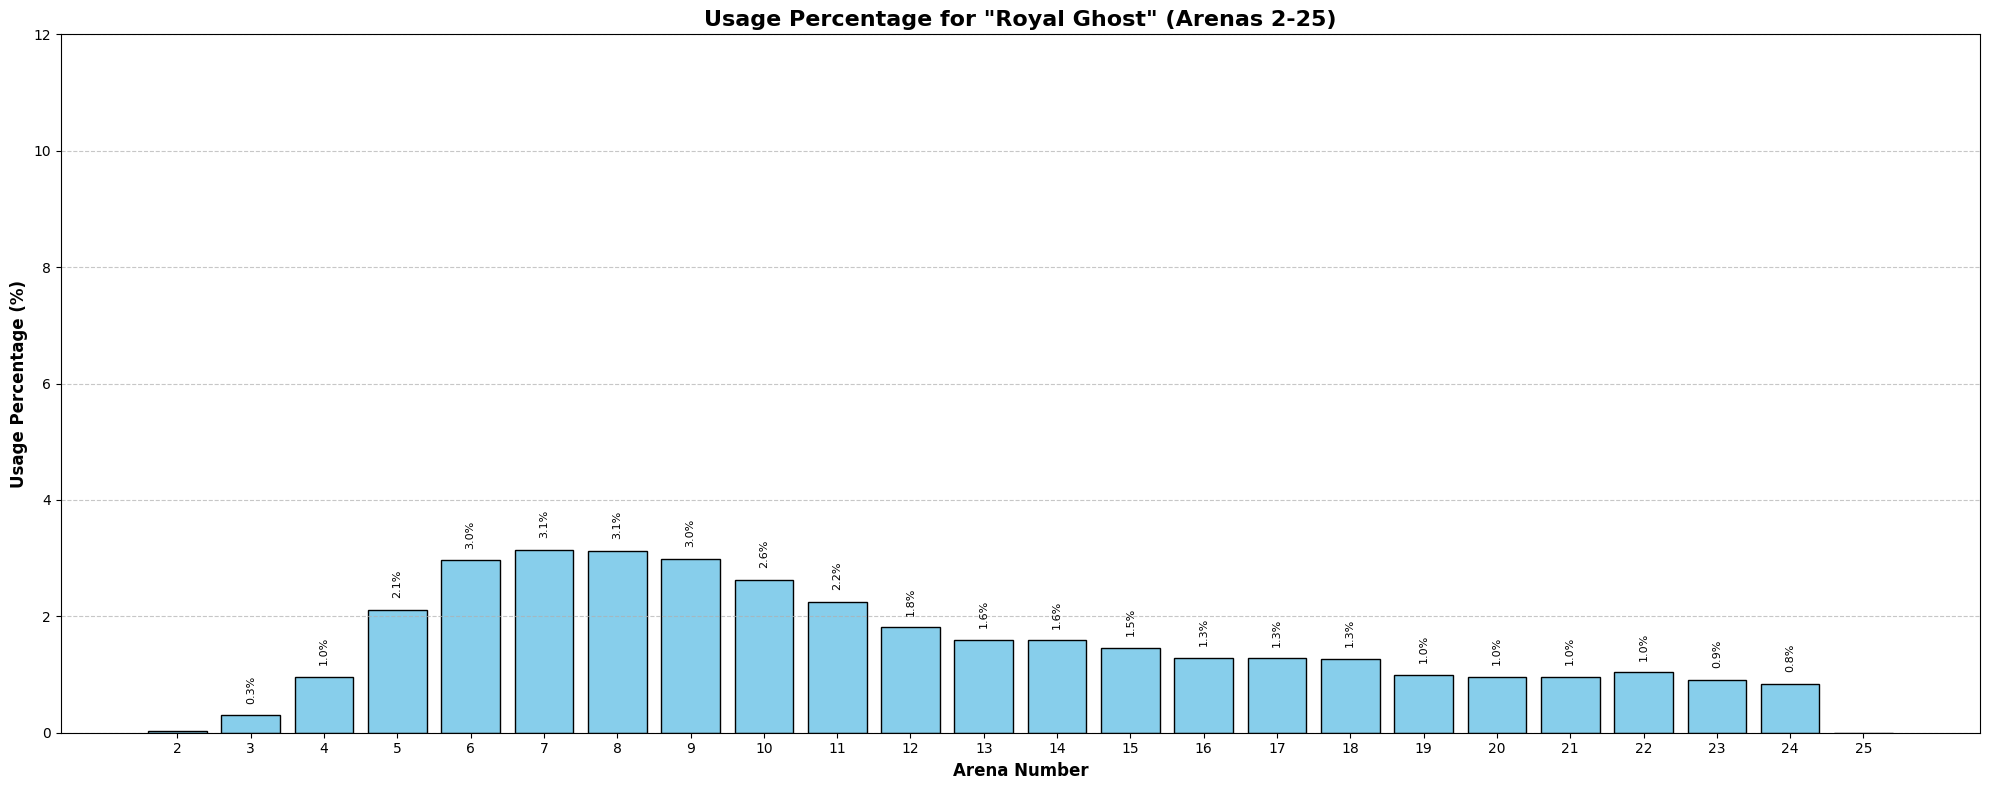

Successfully saved plot: royal_ghost_usage_arenas_2-25.png



'royal_ghost_usage_arenas_2-25.png'

In [15]:
plot_card_percentage_updated(card_percentage_dict, "Royal Ghost")  # Example for a specific card